# <font color='#28B463'>RIDGE REGRESSION

<br>

## <font color='#28B463'>Introduction

<br>
<b>Ridge Regression</b> (also known as Tikhonov regularization, or L2 regularization) <b>is the most commonly used method for regularization of ill-posed problems</b>.

<br>
An ill-posed problem is one which does not meet the three Hadamard criteria for being well-posed; mathematical models of physical phenomena should have all of the following properties :

<br>
<ul style="list-style-type:square">
    <li>
        a solution exists
    </li>    
    <li>
        the solution is unique
    </li>    
    <li>
        the solution behavior changes continuously with the initial conditions
    </li>    
</ul>

<br>
Under such circumstances, we will say that the problem is ill-posed or, equivalently, that the design matrix $\mathbf{X}$ is ill-conditioned. In the notebook regarding the violations of the CLMR assumptions we learned that, <b>in the context of linear regression, the main cause of ill-conditioning is multicollinearity</b>.

<br>
<blockquote style="background-color: #f0f0f5">
In the case of perfect multicollinearity, the design matrix $\mathbf{X}$ has less than full rank, and the matrix $\mathbf{X}^{\top}\mathbf{X}$ cannot be inverted; the ordinary least squares estimator $\boldsymbol{\hat{\beta}_{OLS}}$ does not exist.    
</blockquote>

<br>
<blockquote style="background-color: #f0f0f5">
In the case of non-perfect multicollinearity, the matrix $\mathbf{X}^{\top}\mathbf{X}$ actually has an inverse but a given computer algorithm may or may not be able to compute an approximate inverse. If it does so, the resulting matrix may be <b>highly sensitive to slight variations in the data, and may therefore be very inaccurate or very sample-dependent</b>. The design matrix $\mathbf{X}$ is said to be ill-conditioned, and the parameter vector $\boldsymbol{\beta}$ non-identifiable (for it has no unique solution).
</blockquote>

<br>
<blockquote style="background-color: #f0f0f5">
Another issue with multicollinearity is that <b>small changes to the input data can lead to large changes in the model</b>, even resulting in changes of sign of parameter estimates.
</blockquote>

<br>
Ridge Regression is a technique for analyzing multiple regression data that suffer from multicollinearity; when the latter occurs, least squares estimates are unbiased, but their variances are large so they may be far from the true value. <b>By adding a degree of bias to the regression estimates, ridge regression leads to a decrease in variance</b> (and hence in the prediction error), <b>yielding more reliable estimates</b>. 
   

## <font color='#28B463'>Problems with OLS

<br>
Ordinary least squares (under CLRM assumptions) provides estimates of the regression coefficients that are unbiased and have minimum variance in the class of the other linear unbiased estimators :


<br>
<blockquote style="background-color: #f0f0f5">
$
\begin{align}
    \hat{\boldsymbol{\beta}}_\boldsymbol{OLS} 
    &= \newline
    &= (\mathbf{X}^{\top}\mathbf{X})^{-1} \mathbf{X}^{\top}\mathbf{Y} 
        \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad
        \text{the regressors have been standardized} \quad (\mathbf{X}^{\top}\mathbf{X} = \mathbf{R})
        \newline
    &= \mathbf{R}^{-1} \mathbf{X}^{\top}\mathbf{Y}
\end{align}
$
</blockquote>

<blockquote style="background-color: #f0f0f5">
$
\mathbf{E} \big[ \hat{\boldsymbol{\beta}}_\boldsymbol{OLS} \big] = \boldsymbol{\beta_{OLS}}
$
</blockquote>

<blockquote style="background-color: #f0f0f5">
$
\begin{align}
    \mathrm{V}(\hat{\boldsymbol{\beta}}_\boldsymbol{OLS}) 
    &= \newline
    &= \boldsymbol{\sigma^2} \ (\mathbf{X}^{\top}\mathbf{X})^{-1} 
        \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad
        \text{the regressand too has been standardized} \quad (\boldsymbol{\sigma^2} = 1)
        \newline
    &= \mathbf{R}^{-1}
\end{align}
$
</blockquote>

<br>
This estimation procedure yields reliable estimates if $\ (\mathbf{X}^{\top}\mathbf{X}) \ $, when in the form of a correlation
matrix, is nearly a unit matrix. 

<br>
In the presence of multicollinearity, however, if $ \ (\mathbf{X}^{\top}\mathbf{X}) \ $ is not nearly a unit matrix and we are forced to treat the estimated regression function as a black box (multicollinearity does not reduce the predictive power or reliability of the model as a whole, it only affects calculations regarding individual predictors) or to drop regressors in order to prevent the issue. Both these alternatives are unsatisfactory if the original intent was to use the estimated predictor for control and optimization. 


In [1]:
# SETUP : importing

import numpy as np
import math
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.datasets import load_boston

import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.linear_model as lm
from sklearn.model_selection import KFold

import sklearn.metrics as mtr
from scipy import stats
from statsmodels.stats import diagnostic

import utilcompute as uc
import preprocessing as pre
from pprint import pprint


C:\Users\danis_p50\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data = np.column_stack( (load_boston().data, load_boston().target) )
df = pd.DataFrame(data)
df.columns = [
    'CRIM',    # per capita crime rate by town
    'ZN',      # proportion of residential land zoned for lots over 25,000 sq.ft.
    'INDUS',   # proportion of non-retail business acres per town
    'CHAS',    # Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
    'NOX',     # nitric oxides concentration (parts per 10 million)
    'RM',      # average number of rooms per dwelling
    'AGE',     # proportion of owner-occupied units built prior to 1940
    'DIS',     # weighted distances to five Boston employment centres
    'RAD',     # index of accessibility to radial highways
    'TAX',     # full-value property-tax rate per $10,000
    'PTRATIO', # pupil-teacher ratio by town
    'B',       # 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    'LSTAT',   # % lower status of the population
    'MEDV'     # median value of owner-occupied homes in $1000's
]

In [3]:
# SETUP : printing aggregated info

#print(load_boston().DESCR)
s = uc.summary(df)
print(s)

           dtype nan_tot nan_prc nan_resp_prc uniques_tot uniques_prc
CRIM     float64       0       0            0         504        99.6
ZN       float64       0       0            0          26        5.14
INDUS    float64       0       0            0          76       15.02
CHAS     float64       0       0            0           2         0.4
NOX      float64       0       0            0          81       16.01
RM       float64       0       0            0         446       88.14
AGE      float64       0       0            0         356       70.36
DIS      float64       0       0            0         412       81.42
RAD      float64       0       0            0           9        1.78
TAX      float64       0       0            0          66       13.04
PTRATIO  float64       0       0            0          46        9.09
B        float64       0       0            0         357       70.55
LSTAT    float64       0       0            0         455       89.92
MEDV     float64    

In [4]:
target = 'MEDV'

if (isinstance(target, list)):
    features = [c for c in df.columns.values.tolist() if (c not in target)]
else:
    features = [c for c in df.columns.values.tolist() if (c != target)]

#print('features : ', features)
#print('target   : ', target)

In [5]:
#fig, axs = plt.subplots(nrows = len(features), ncols = 1, figsize=(20, 4 * len(features)))    

#for (f_index, f) in enumerate(features) :
#    ax = axs[f_index]
#    subset = df[f]        
#    sns.distplot(a= subset, ax = ax, label = f)   
#    ax.axvline(x = subset.mean(), linestyle='--')
#    ax.legend(loc='best') 

#plt.tight_layout()
#plt.show()

In [6]:
# SHUFFLING 

seed = 10
np.random.seed(seed)

df = df.reindex(np.random.permutation(df.index))


In [7]:
def update_influence_stats(df, features, target, sm_results):
    if (
        df.empty
        or not features
        or not target
        or not sm_results
    ):
        return
    
    df_temp = df.copy(deep = True)
        
    influence = sm_results.get_influence()

    studentized_residuals = influence.resid_studentized_external
    leverage = influence.hat_matrix_diag
    (cooks, p) = influence.cooks_distance
    (dffits, p) = influence.dffits

    df_temp['st_res'] = studentized_residuals
    df_temp['leverage'] = leverage
    df_temp['cooks'] =  cooks
    df_temp['dffits'] = dffits
    
    return df_temp


In [8]:
def compute_influence_cutoffs(df, features, target):    
    if (
        df.empty
        or not features
        or not target
    ):
        return
        
    n = len(df)
    p = len(features)
    
    st_res_threshold = 2
    lev_threshold = 3*(p/n)
    cooks_threshold = 4 / (n - p - 1)
    dffits_threshold = 2 * np.sqrt( (p+1) / (n - p - 1) )   
    
    d = {
        'st_res_threshold' : st_res_threshold,
        'lev_threshold'    : lev_threshold,
        'cooks_threshold'  : cooks_threshold,
        'dffits_threshold' : dffits_threshold        
    }
    
    return d

In [9]:
def plot_influential_point(df):
    if (
        df.empty
        or 'st_res' not in df.columns
        or 'leverage' not in df.columns
        or 'cooks' not in df.columns
        or 'dffits' not in df.columns
    ):
        return
    
    d = compute_influence_cutoffs(df = df, features = features, target = target)
    
    criteria_list = [
        (abs(df['st_res']) > d['st_res_threshold']) & (df['leverage'] > d['lev_threshold']),
        (df['cooks'] > d['cooks_threshold']) ,
        (abs(df['dffits']) > d['dffits_threshold']) 
    ]
    
    fig, axs = plt.subplots(nrows = 1, ncols = len(criteria_list), figsize=(20, 5), sharey = True)    
    current_pal = sns.color_palette()
    
    titles = ['', "cook's distance", 'dffits']
    
    for (criteria_index, criteria) in enumerate(criteria_list) :
        ax = axs[criteria_index]
        
        subset = df[np.logical_not(criteria)]
        x = np.sqrt(subset['st_res'] ** 2)
        ax.scatter(x, subset['leverage'], color = current_pal[0], label = 'non influential')
        
        subset = df[criteria]
        x = np.sqrt(subset['st_res'] ** 2)
        prc = round( (len(subset) / len(df)) * 100, 2)
        ax.scatter(x, subset['leverage'], color = current_pal[2], label = 'influential ({0} %)'.format(prc))
        
        #ax.set_ylim(bottom = -0.005)
        ax.plot((d['st_res_threshold'],d['st_res_threshold']), (0,ax.get_ylim()[1]), 
                color = current_pal[0], linestyle = '--', linewidth = 3)  
        ax.plot((0,ax.get_xlim()[1]), (d['lev_threshold'],d['lev_threshold']), 
                color = current_pal[0], linestyle = '--', linewidth = 3)
        
        ax.legend(loc='best')
        ax.set_xlabel('st_res')
        ax.set_ylabel('leverage')
        ax.set_title(titles[criteria_index])
        
    plt.show()
    

In [10]:
def compute_kfold_stats(df, features, target, linear_model_name, linear_model_args, note):
    
    n_splits = 10
    kf = KFold(n_splits = n_splits, shuffle = False, random_state = None)    
    
    columns = [
        'linear_model_name', 'note', 'iteration', 
        'residuals', 'res_normality', 'res_homoscedasticity',
        'err_train', 'err_test'
    ] + ['intercept', 'coef'] + features
    results_df = pd.DataFrame(data = None, index = None, columns = columns)


    kf = KFold(n_splits = n_splits, shuffle = False, random_state = None)    
    for k, (train_positions, test_positions) in enumerate(kf.split(X = df[features], y = df[target])) :

        fold_train = df.iloc[train_positions]   
        fold_test = df.iloc[test_positions]  

        linear_model_class_ = getattr(lm, linear_model_name)
        if (linear_model_args):
            model = linear_model_class_(**linear_model_args)
        else:
            model = linear_model_class_()
        
        model.fit(fold_train[features], fold_train[target])

        y_pred_train = model.predict(fold_train[features])
        y_pred_test = model.predict(fold_test[features])
        
        residuals_train = (fold_train[target] - y_pred_train)
        residuals_test = (fold_test[target] - y_pred_test)
        
        res_normality = stats.shapiro(residuals_test)[0]
        res_homoscedasticity = diagnostic.het_breuschpagan(resid = residuals_test, exog_het = fold_test[features])[3]

        r2_train = mtr.r2_score(y_true = fold_train[target], y_pred = y_pred_train)
        r2_test = mtr.r2_score(y_true = fold_test[target], y_pred = y_pred_test)
        
        values_dict = {
            'linear_model_name' : linear_model_name,
            'note'              : note,
            'iteration'         : k + 1,      
            
            'residuals'            : residuals_test,
            'res_normality'        : res_normality,
            'res_homoscedasticity' : res_homoscedasticity,
            
            'err_train'         : 1 - r2_train,
            'err_test'          : 1 - r2_test,
            
            'intercept'         : model.intercept_, 
            'coef'              : model.coef_
        }

        for f in range(len(features)):
            values_dict[features[f]] = model.coef_[f]
        
        results_index = k
        results_df.loc[results_index] = values_dict     

    #results_df = results_df.astype(dtype = 'float')
        
    return results_df


studentized residuals    :         2
leverage                 :    0.0771
cook's distance          :    0.0081
dffits                   :    0.3374


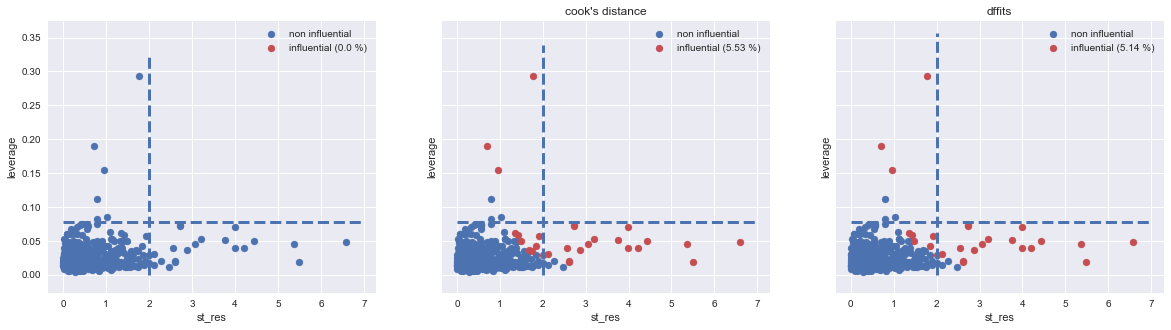

In [11]:
results = sm.OLS(df[target], df[features]).fit()

df = update_influence_stats(df = df, features = features, target = target, sm_results = results)

d = compute_influence_cutoffs(df = df, features = features, target = target)
template = "{0:<25}:{1:>10}" 
print(template.format('studentized residuals', d['st_res_threshold']))
print(template.format('leverage', round(d['lev_threshold'], 4)))
print(template.format("cook's distance", round(d['cooks_threshold'], 4)))
print(template.format('dffits', round(d['dffits_threshold'], 4)))

plot_influential_point(df = df)

In [12]:
influential_criteria = ( 
    (abs(df['st_res']) > d['st_res_threshold']) & (df['leverage'] > d['lev_threshold']) 
    & (df['cooks'] > d['cooks_threshold'])
)

index_list = df[influential_criteria].index.values.tolist()

df_temp = df.copy(deep = True)
results = compute_kfold_stats(
        df = df_temp, 
        features = features, 
        target = target, 
        linear_model_name = 'LinearRegression', 
        linear_model_args = None,
        note = 0
    )
for (index_pos, index) in enumerate(index_list):  
    #print('number of features removed : {0}'.format(len(df) - len(df_temp)))
    results_temp = compute_kfold_stats(
        df = df_temp, 
        features = features, 
        target = target, 
        linear_model_name = 'LinearRegression', 
        linear_model_args = None,
        note = index_pos + 1
    )
    results = results.append(results_temp).reset_index(drop = True)
    index = index_list[index_pos]
    #print('i: {0} | index : {1}'.format(index_pos, index))
    df_temp.drop(labels = index, axis = 0, inplace = True)

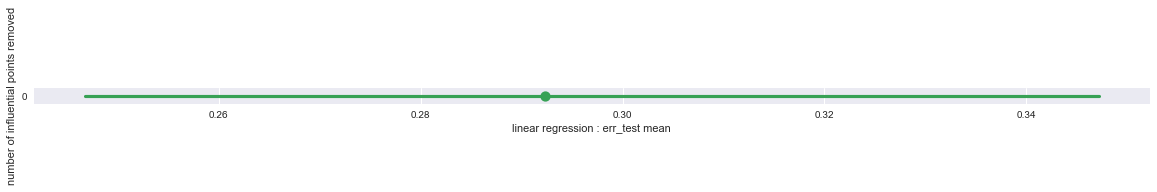

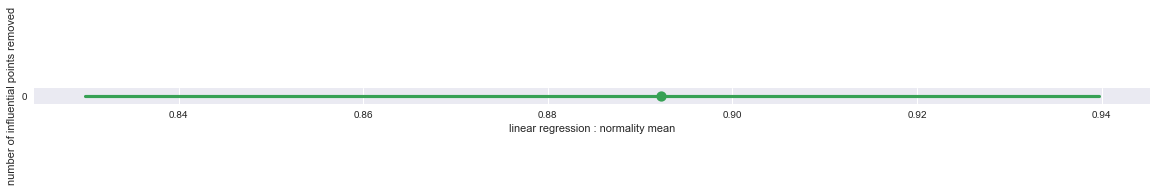

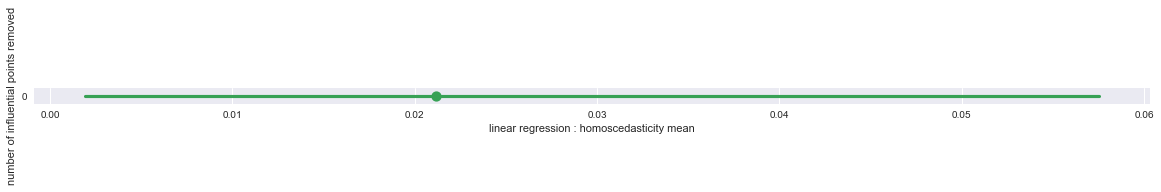

In [13]:
discriminant_values = results['note'].unique()

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 0.3*len(discriminant_values)))
pal = sns.color_palette("Greens_d", len(discriminant_values))

ax = axs    
#sns.barplot(x = 'err_test', y = 'note', data = results, order = discriminant_values, ci = None, ax = ax, palette = pal) 
sns.pointplot(x = 'err_test', y = 'note', data = results, estimator = np.mean, orient = 'h', ax = ax, palette = pal)
ax.set_xlabel('linear regression : err_test mean')
ax.set_ylabel('number of influential points removed')

plt.show()


fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 0.3*len(discriminant_values)))
pal = sns.color_palette("Greens_d", len(discriminant_values))

ax = axs 
sns.pointplot(x = 'res_normality', y = 'note', data = results, estimator = np.mean, orient = 'h', ax = ax, palette = pal)
ax.set_xlabel('linear regression : normality mean')
ax.set_ylabel('number of influential points removed')

plt.show()



fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 0.3*len(discriminant_values)))
pal = sns.color_palette("Greens_d", len(discriminant_values))

ax = axs 
sns.pointplot(x = 'res_homoscedasticity', y = 'note', data = results, estimator = np.mean, orient = 'h', ax = ax, palette = pal)
ax.set_xlabel('linear regression : homoscedasticity mean')
ax.set_ylabel('number of influential points removed')

plt.show()


In [14]:
df = df_temp

In [15]:
# SETUP : data split

train_perc = 0.8
delimiter = int(len(df) * train_perc)

df_train = pd.DataFrame( df[:delimiter] ) # train + validation
df_test = pd.DataFrame( df[delimiter:] )  # test


## <font color='#28B463'>Assumptions

<br>
The assumptions are the same as those used in regular multiple regression: linearity, homoscedasticity, and independence. Since ridge regression does not provide confidence limits, normality need not be assumed.


## <font color='#28B463'>Standardization

<br>
In ridge regression, the first step is to standardize the variables (both dependent and independent) by subtracting
their means and dividing by their standard deviations :

<br>
$
    \quad
    \boldsymbol{X_i}^{\star}  = \dfrac {\boldsymbol{X_i} – \mu_X} {\sigma_X}
$

<br>
This would cause a change in notation, since we should indicate whether the variables in a particular formula are standardized or not; to keep things simple, in this notebook we will make the following general statement and then forget about notation.

<br>
As far as standardization is concerned, <b>all ridge regression calculations are based on standardized variables; when
the final regression coefficients are displayed, they are adjusted back into their original scale</b>. The ridge trace, however, is in a standardized scale.

In [16]:
# DATA PREPROCESSING (TRAIN + VALIDATION) : features transformation

#df_sk = pd.DataFrame()
#for (f_index, f) in enumerate(features):
#    subset = df_train[f]
#    log_modulus_transform = np.sign(subset) * np.log10(np.abs(subset) + 1)
#    if (abs(stats.skew(log_modulus_transform)) < abs(stats.skew(subset))) :
        #df_sk[f] = np.sqrt(df_train[f])
#        df_sk[f] = log_modulus_transform
#    else:
#        df_sk[f] = subset
#df_sk[target] =  df_train[target]

excluded_features = ['CHAS']
included_features = [f for f in features if (f not in excluded_features)]
#df_cnt = pre.center(df = df_sk, included = features, excluded = target)
#df_std = pre.standardize(df = df_sk, included = features, excluded = target)

df_cnt = pre.center(df = df, included = included_features, excluded = uc.concatenate(excluded_features,target))
df_std = pre.standardize(df = df, included = included_features, excluded = uc.concatenate(excluded_features,target))


In [17]:
# DATA PREPROCESSING (TEST) : features transformation

#df_sk_test = pd.DataFrame()
#for (f_index, f) in enumerate(features):
#    df_sk_test[f] = np.sqrt(df_test[f])
#df_sk_test[target] =  df_test[target]

#df_cnt_test = pre.center(df = df_sk_test, included = features, excluded = target)
#df_std_test = pre.standardize(df = df_sk_test, included = features, excluded = target)

df_cnt_test = pre.center(df = df_test, included = features, excluded = target)
df_std_test = pre.standardize(df = df_test, included = features, excluded = target)


### <font color='#28B463'>Impact on the transformed features

<br>

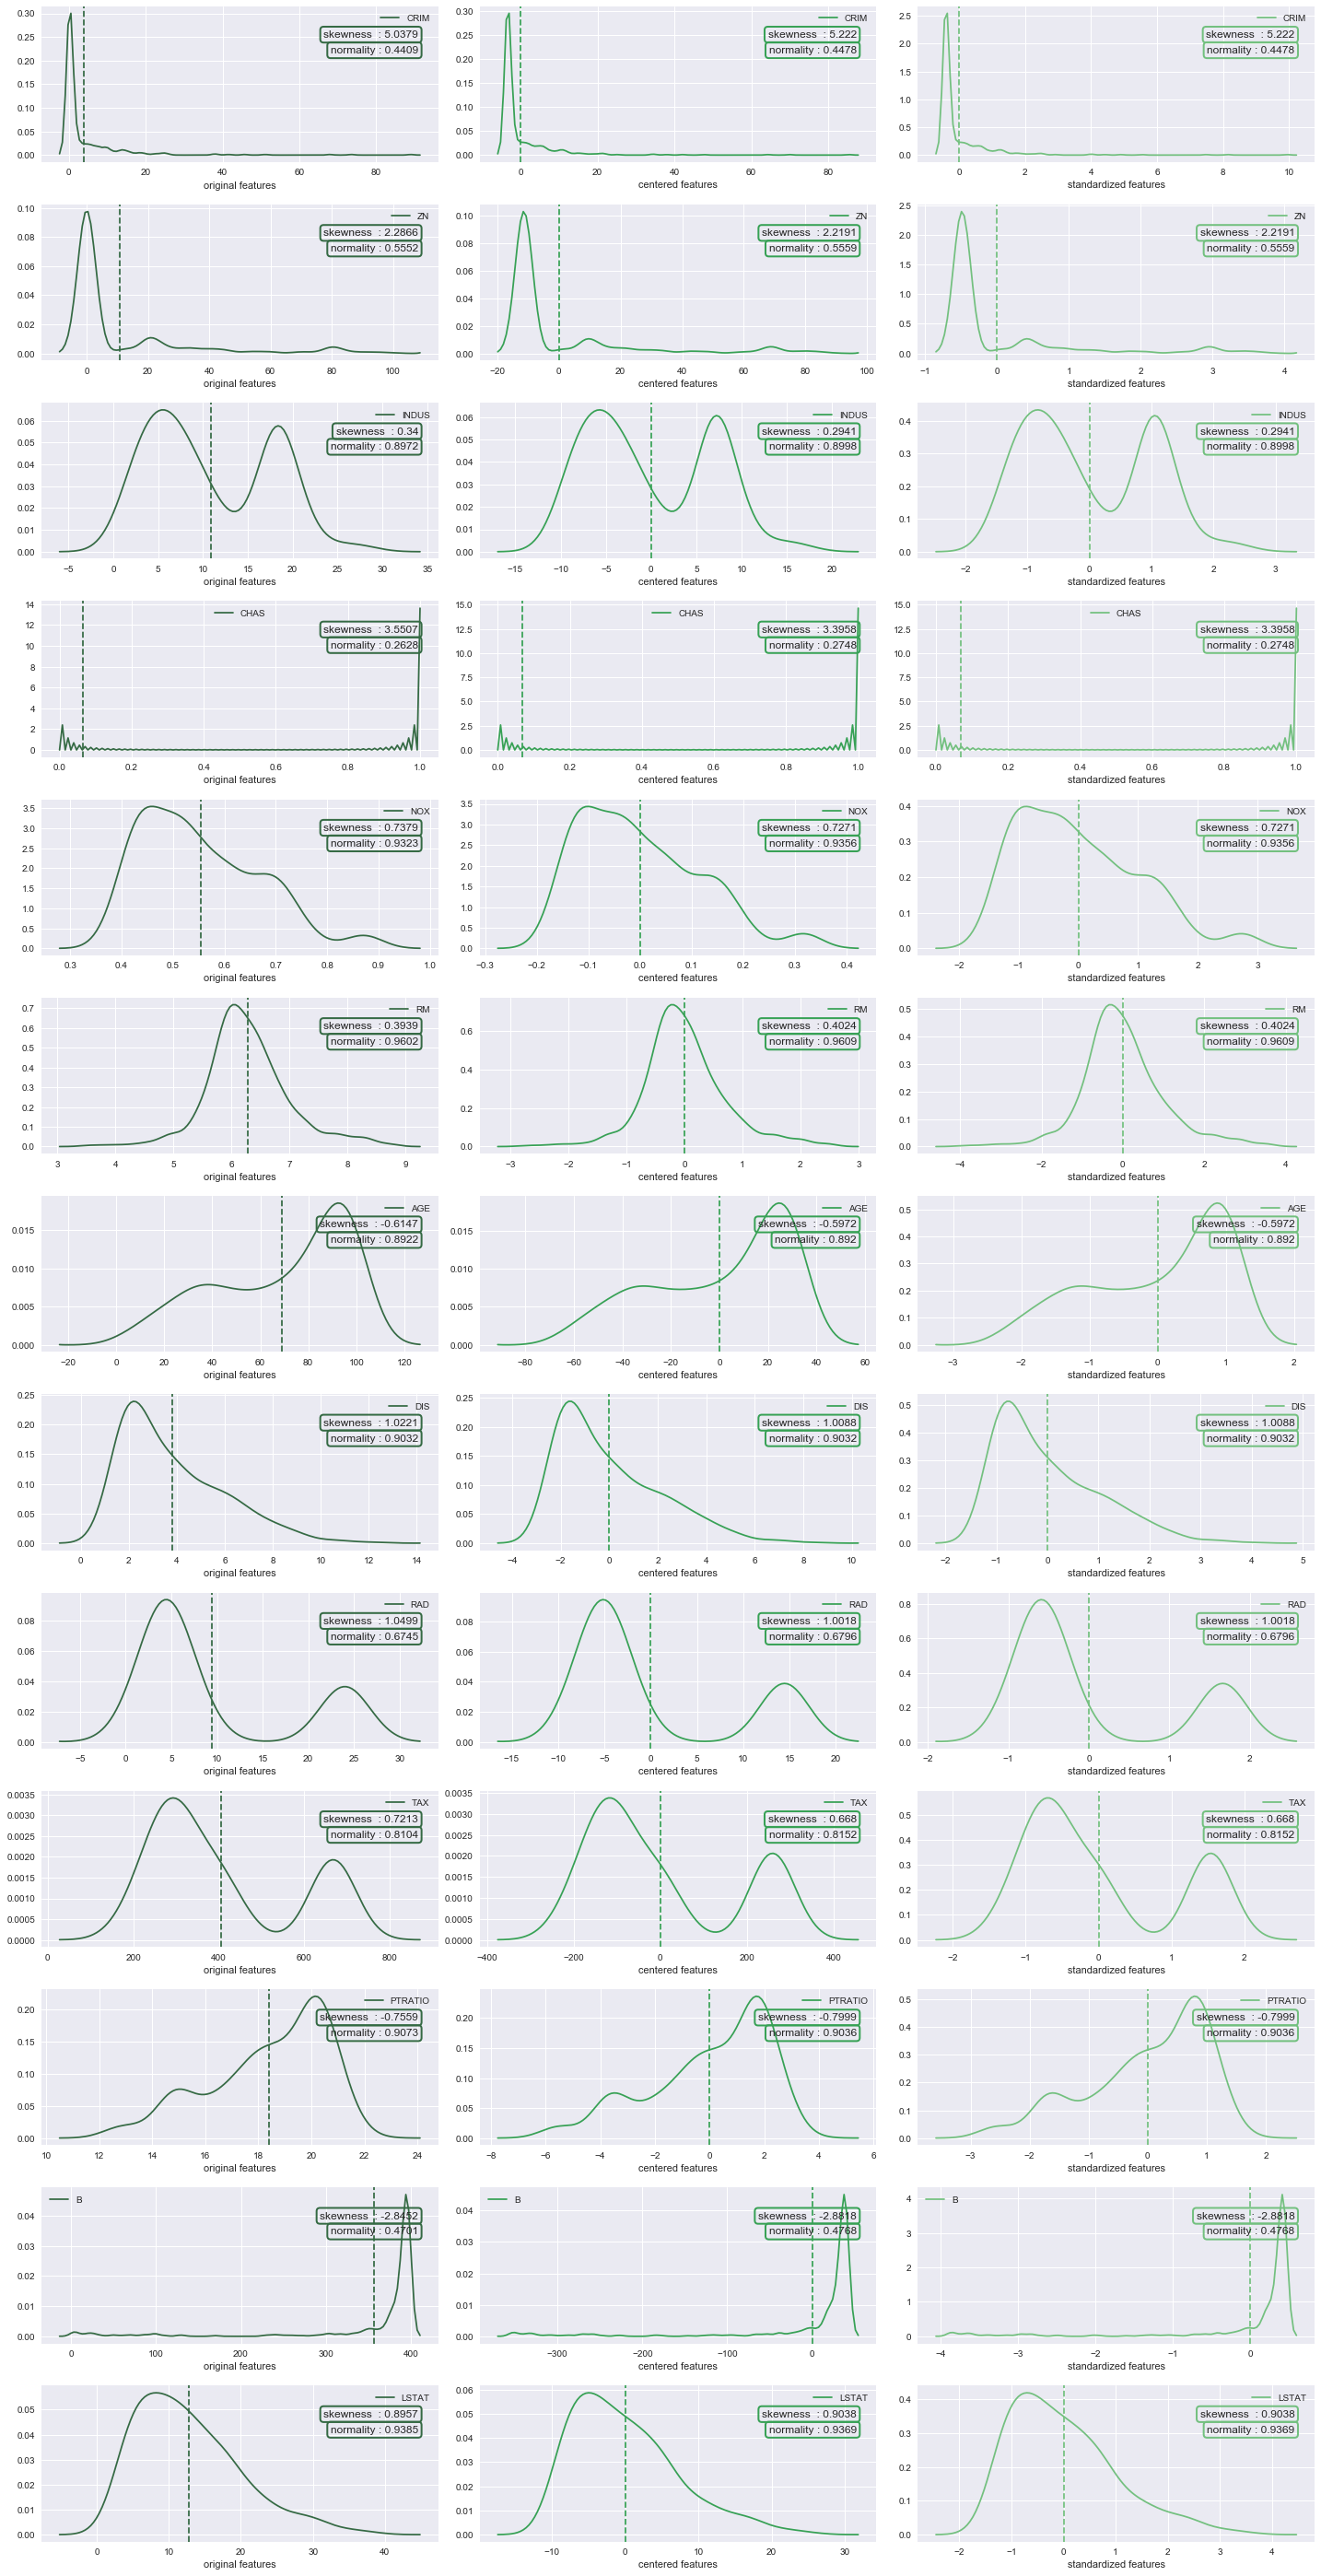

In [18]:
plot_list = [
    { 'df' : df_train, 'xlabel' : 'original features',     'legend_loc' : 'best'},
    #{ 'df' : df_sk,    'xlabel' : 'un-skewed features',    'legend_loc' : 'best'},
    { 'df' : df_cnt,   'xlabel' : 'centered features',     'legend_loc' : 'best'},
    { 'df' : df_std,   'xlabel' : 'standardized features', 'legend_loc' : 'best'}
]

visualized_features = features

n_cols = len(plot_list)
fig, axs = plt.subplots(nrows = len(visualized_features), ncols = n_cols, figsize=(20, n_cols * len(visualized_features)))    
pal = sns.color_palette("Greens_d", n_cols)

p = 0
for (pl_index, pl_dict) in enumerate(plot_list):      
    for (f_index,f) in enumerate(visualized_features) :
        ax = axs[f_index][pl_index] 
        subset = pl_dict['df'][f]       
        
        skewness = round(stats.skew(subset),4)
        normality = round(stats.shapiro(subset)[0],4)
        
        sns.distplot(a = subset, hist = False, kde = True, rug = False, color = pal[p], ax = ax, label = f)   
        ax.axvline(x = subset.mean(), color = pal[p], linestyle='--')
        
        ax.text(x = 0.95, y = 0.8, horizontalalignment='right', s = ('skewness  : {0}'.format(skewness)),  
            transform = ax.transAxes, bbox = dict(boxstyle = "round, pad=0.3", fill = False, ec = pal[p], lw = 2))
        ax.text(x = 0.95, y = 0.7, horizontalalignment='right', s = ('normality : {0}'.format(normality)),  
            transform = ax.transAxes, bbox = dict(boxstyle = "round, pad=0.3", fill = False, ec = pal[p], lw = 2))        
        
        ax.set_xlabel(pl_dict['xlabel'])
        ax.legend(loc = pl_dict['legend_loc'])
    p += 1
        

plt.tight_layout()
plt.show()


### <font color='#28B463'>Impact on the VIF

<br>

In [19]:
vif_dict = uc.compute_vif(df = df_train, features = features)
print('df : ')
print()
pprint(vif_dict)

#vif_dict = uc.compute_vif(df = df_sk, features = features)
#print('df_sk : ')
#print()
#pprint(vif_dict)

vif_dict = uc.compute_vif(df = df_cnt, features = features)
print()
print('df_cnt : ')
print()
pprint(vif_dict)

vif_dict = uc.compute_vif(df = df_std, features = features)
print()
print('df_std : ')
print()
pprint(vif_dict)


df : 

{'AGE': 21.085377182788623,
 'B': 19.308766366933597,
 'CHAS': 1.1573651027320662,
 'CRIM': 2.0417992713406399,
 'DIS': 15.07478147489034,
 'INDUS': 15.54055462596029,
 'LSTAT': 11.305867376756563,
 'NOX': 77.056893340084528,
 'PTRATIO': 85.591394916430957,
 'RAD': 15.360997909419789,
 'RM': 74.34789980696101,
 'TAX': 65.647600468489713,
 'ZN': 3.0296233914695345}

df_cnt : 

{'AGE': 3.1002673392586724,
 'B': 1.3455646446773106,
 'CHAS': 1.0684777345909893,
 'CRIM': 1.7729990647080087,
 'DIS': 3.9564782116784736,
 'INDUS': 3.9880590549909218,
 'LSTAT': 2.9373521677485379,
 'NOX': 4.3947004495473658,
 'PTRATIO': 1.7980519223650238,
 'RAD': 7.4741562378536273,
 'RM': 1.9340236998152587,
 'TAX': 8.9986963568189147,
 'ZN': 2.2986043674832954}

df_std : 

{'AGE': 3.1002673392586724,
 'B': 1.3455646446773109,
 'CHAS': 1.0684777345909893,
 'CRIM': 1.7729990647080087,
 'DIS': 3.9564782116784736,
 'INDUS': 3.9880590549909218,
 'LSTAT': 2.9373521677485388,
 'NOX': 4.3947004495473641,
 'PT

In [20]:
def compute_holdout_stats(df_train, df_test, features, target, linear_model_name, linear_model_args, note):
    
    linear_model_class_ = getattr(lm, linear_model_name)
    if (linear_model_args):
        model = linear_model_class_(**linear_model_args)
    else:
        model = linear_model_class_()
        
    model.fit(df_train[features], df_train[target])

    y_pred_train = model.predict(df_train[features])
    y_pred_test = model.predict(df_test[features])

    r2_train = mtr.r2_score(y_true = df_train[target], y_pred = y_pred_train)
    r2_test = mtr.r2_score(y_true = df_test[target], y_pred = y_pred_test)
        
    values_dict = {
        'linear_model_name' : linear_model_name,
        'note'              : note,     
        'y_pred_train'      : y_pred_train,
        'y_pred_test'       : y_pred_test,
        'residuals_train'   : (df_train[target] - y_pred_train),
        'residuals_test'    : (df_test[target] - y_pred_test),
        'err_train'         : 1 - r2_train,
        'err_test'          : 1 - r2_test        
    }
        
    return values_dict


In [21]:
linear_list = [
    { 'df' : df_train,     'linear_model_name' : 'LinearRegression', 
     'linear_model_args' : {'fit_intercept' : True}, 'note' : 'original' },
    #{ 'df' : df_sk,     'linear_model_name' : 'LinearRegression', 
    # 'linear_model_args' : {'fit_intercept' : True}, 'note' : 'un-skewed' },
    { 'df' : df_cnt, 'linear_model_name' : 'LinearRegression', 
     'linear_model_args' : {'fit_intercept' : True}, 'note' : 'centered' },
    { 'df' : df_std, 'linear_model_name' : 'LinearRegression', 
     'linear_model_args' : {'fit_intercept' : True}, 'note' : 'standardized'}    
]

results = pd.DataFrame()

for l in linear_list:
    results_temp = compute_kfold_stats(
        df = l['df'], 
        features = features, 
        target = target, 
        linear_model_name = l['linear_model_name'], 
        linear_model_args = l['linear_model_args'],
        note = l['note']
    )
    results = results.append(results_temp).reset_index(drop = True)

#print(results[['note','intercept', 'err_test']])

## <font color='#28B463'>Derivation

<br>
From the previous notebooks we know that the coefficients estimates are found by minimizing a so-called cost function; here a comparison of this cost function in the context of OLS (residual sum of squares) and Ridge Regression (penalized sum of squares) :

<br>
<blockquote style="background-color: #f0f0f5">
$
    \begin{align}
        S_{OLS}(\hat{\boldsymbol{\beta}}) 
        &= 
        \newline
        &= \sum _{i=1}^{N}(\boldsymbol{\mathbf{Y}_i} - \boldsymbol{\mathbf{X}_i}^{\top} \hat{\boldsymbol{\beta}})^{2}
        \newline
        &= (\mathbf{Y} - \mathbf{X} \hat{\boldsymbol{\beta}})^{T} (\mathbf{Y} - \mathbf{X} \hat{\boldsymbol{\beta}})            
    \end{align}
$
</blockquote>

$
    \quad
    \begin{align}
        S_{R}(\hat{\boldsymbol{\beta}})    
        &= 
        \newline
        &= 
            S_{OLS}(\hat{\boldsymbol{\beta}}) 
            + \boldsymbol{\lambda} \sum _{j=1}^{p} {\hat{\boldsymbol{\beta}}_\boldsymbol{j}}^{2}
        \newline
        &= 
            \sum _{i=1}^{N}(\boldsymbol{\mathbf{Y}_i} - \boldsymbol{\mathbf{X}_i}^{\top} \hat{\boldsymbol{\beta}})^{2}
            + \boldsymbol{\lambda} \sum _{j=1}^{p} {\hat{\boldsymbol{\beta}}_\boldsymbol{j}}^{2}
        \newline
        &= 
            (\mathbf{Y} - \mathbf{X} \hat{\boldsymbol{\beta}})^{T} (\mathbf{Y} - \mathbf{X} \hat{\boldsymbol{\beta}})  
            + \lambda \ ( \ \hat{\boldsymbol{\beta}}^{\top}\hat{\boldsymbol{\beta}} \ )
    \end{align}
$





<br>
$
    \quad
    \hat{\boldsymbol{\beta}}_\boldsymbol{OLS}
    = {\rm {arg}}\min _{\hat{\beta} \in \mathbb{R}^{p}} S(\hat{\beta})
    = 
        \left({\dfrac {1}{n}}\sum_{i=1}^{n} \mathbf{X}_{i}\mathbf{X}_{i}^{\top}\right)^{\!-1}\!\!\cdot \,
        {\dfrac {1}{n}}\sum _{i=1}^{n}\mathbf{X}_{i}\mathbf{Y}_{i}
$

<br>
Just like we saw with OLS, the derivation of the ridge estimator is performed in two stages :

<ul style="list-style-type:square">
    <li>
        <b>stage 1</b> consists of determining the first-order conditions (FOC, also known as normal equations) for minimizing
        the penalized residual sum of squares function PRSS;
    </li>
    <br>
    <li>
        <b>stage 2</b> consists of solving the normal equations in order to obtain the explicit expressions for the 
        estimators
    </li>
</ul>

<br>
<font color='#28B463'><b>Partial Differentiation</b></font>

<br>
$
    \quad
    \begin{align}
        \dfrac
            {\partial \ PRSS}
            {\partial \ \hat{\boldsymbol{\beta}}_\boldsymbol{R} }
        &= 
        \newline
        &=
            \dfrac
                {\partial \ RSS}
                {\partial \ \hat{\boldsymbol{\beta}}_\boldsymbol{R} }
            + \dfrac
                {\partial \ \text{penalty term}}
                {\partial \ \hat{\boldsymbol{\beta}}_\boldsymbol{R} }
        \newline
        &= 
            - 2 \ \mathbf{X}^{\top} \mathbf{Y}
            + 2 \ \mathbf{X}^{\top} \mathbf{X} \ \hat{\boldsymbol{\beta}}_\boldsymbol{R}      
            + 2 \ \lambda \ \hat{\boldsymbol{\beta}}_\boldsymbol{R}     
    \end{align}     
$

<br>
<font color='#28B463'><b>Solving the normal equations</b></font>

<br>
$
    \quad
    \begin{align}
        & \qquad
            - 2 \mathbf{X}^{\top} \mathbf{Y}
            + 2 \mathbf{X}^{\top} \mathbf{X} \ \hat{\boldsymbol{\beta}}_\boldsymbol{R}      
            + 2 \ \lambda \ \hat{\boldsymbol{\beta}}_\boldsymbol{R} = 0
        \newline
        \Rightarrow & \qquad
            \hat{\boldsymbol{\beta}}_\boldsymbol{R} \left( \mathbf{X}^{\top} \mathbf{X} + \lambda \ \mathbf{I} \right)
            = \mathbf{X}^{\top} \mathbf{Y}
        \newline
        \Rightarrow & \qquad
            \hat{\boldsymbol{\beta}}_\boldsymbol{R}
            = \big[ \mathbf{X}^{\top} \mathbf{X} + \lambda \ \mathbf{I} \big]^{-1} \ \mathbf{X}^{\top} \mathbf{Y}
    \end{align}
$

## <font color='#28B463'>Ridge Estimator

<br>
Ridge regression proceeds by adding a small positive value $\lambda$ (usually less than 1) to the diagonal elements of the correlation matrix; for any design matrix $\mathbf{X}$, the quantity $(\mathbf{X}^{\top}\mathbf{X} + \lambda \mathbf{I})$
is always invertible and there will always be a unique solution for $\hat{\boldsymbol{\beta}}_\boldsymbol{R} $ :


<br>
$
    \quad
    \begin{align}
        \hat{\boldsymbol{\beta}}_\boldsymbol{R} 
        &= 
        \newline
        & = 
            \underbrace{ (\mathbf{R} + \lambda \mathbf{I})^{-1} } _{ \mathbf{W} } \ \mathbf{X}^{\top}\mathbf{Y}     
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad & [\textbf{E1-A}] 
        \newline \newline
        &= \big[ \mathbf{R} \ (\mathbf{I} + \lambda \mathbf{R}^{-1}) \big]^{-1} \mathbf{X}^{\top}\mathbf{Y} 
            & (AB)^{-1} = B^{-1} A^{-1}
        \newline
        &= \big[ \mathbf{I} + \lambda \mathbf{R}^{-1} \big]^{-1} \mathbf{R}^{-1} \mathbf{X}^{\top}\mathbf{Y} 
        \newline
        &= 
            \underbrace{ \big[ \mathbf{I} + \lambda \mathbf{R}^{-1} \big]^{-1} } _{ \mathbf{Z} } 
            \ \hat{\boldsymbol{\beta}}_\boldsymbol{OLS}  
                & [\textbf{E1-B}] 
        \newline \newline
        &= \mathbf{Z} \ \hat{\boldsymbol{\beta}}_\boldsymbol{OLS}  
            & [\textbf{E1-C}] 
    \end{align}
$

<br>
$
    \quad
    \begin{align}
        \mathbf{W} 
        &=
        \newline
        &= (\mathbf{R} + \lambda \mathbf{I})^{-1}
        \newline
        &= \big[ (\mathbf{I} + \lambda \mathbf{R}^{-1}) \mathbf{R} \big] ^{-1}
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad 
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad & (AB)^{-1} = B^{-1} A^{-1}            
        \newline
        &= \mathbf{R}^{-1} \ \big[ \mathbf{I} + \lambda \mathbf{R}^{-1} \big] ^{-1}
        \newline
        &= \mathbf{R}^{-1} \ \mathbf{Z}
            & [\textbf{E2-A}]
        \newline\newline
        \mathbf{Z} &= \mathbf{R} \ \mathbf{W} 
            & [\textbf{E2-B}]
    \end{align}   
$


In [22]:
alpha = 10**(2)

ridge_list = [
    { 'df' : df_train,     'linear_model_name' : 'Ridge', 
     'linear_model_args' : {'alpha' : alpha, 'fit_intercept' : True}, 'note' : 'original' },
    #{ 'df' : df_sk,     'linear_model_name' : 'Ridge', 
    # 'linear_model_args' : {'alpha' : alpha, 'fit_intercept' : True}, 'note' : 'un-skewed' },
    { 'df' : df_cnt, 'linear_model_name' : 'Ridge', 
     'linear_model_args' : {'alpha' : alpha, 'fit_intercept' : True}, 'note' : 'centered' },
    { 'df' : df_std, 'linear_model_name' : 'Ridge', 
     'linear_model_args' : {'alpha' : alpha, 'fit_intercept' : True}, 'note' : 'standardized'}    
]

results_ridge = pd.DataFrame()

for l in ridge_list:
    results_temp = compute_kfold_stats(
        df = l['df'], 
        features = features, 
        target = target, 
        linear_model_name = l['linear_model_name'], 
        linear_model_args = l['linear_model_args'],
        note = l['note']
    )
    results_ridge = results_ridge.append(results_temp).reset_index(drop = True)

#print(results_ridge[['note','intercept', 'err_test']])

It can be shown that there exists a value of $\lambda$ for which the mean squared error (the variance plus the bias squared)
of the ridge estimator is less than that of the least squares estimator. Unfortunately, the appropriate value of $\lambda$
depends on knowing the true regression coefficients (which are only being estimated) and an analytic solution has not
been found that guarantees the optimality of the ridge solution.

## <font color='#28B463'>Bias

<br>
We know that ridge estimation produces a biased estimator of the true parameters $\boldsymbol{\beta}$, but how large is this bias , and how does it behave ?

<br>
$
    \quad
    \begin{align}
        \mathbf{E} \big[ \hat{\boldsymbol{\beta}}_\boldsymbol{R} \big] 
            &= & \text{by } \textbf{E1-B} 
            \newline
            &=  \mathbf{E} 
                \bigg[ 
                    \big( \mathbf{I} + \lambda \mathbf{R}^{-1} \big)^{-1} \ \hat{\boldsymbol{\beta}}_\boldsymbol{OLS}  
                \bigg] 
            \newline
            &= 
                \big[ \mathbf{I} + \lambda \mathbf{R}^{-1} \big]^{-1} \ 
                \mathbf{E} \big[ \hat{\boldsymbol{\beta}}_\boldsymbol{OLS} \big]
            \newline
            &=  \big[ \mathbf{I} + \lambda \mathbf{R}^{-1} \big]^{-1} \ \boldsymbol{\beta}
                \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad
                \qquad \qquad \qquad \qquad \qquad \qquad \qquad \quad &  [\textbf{E3-A}] 
            \newline \newline
            &= \mathbf{Z} \ \boldsymbol{\beta}  
                &  [\textbf{E3-B}] 
            \newline \newline
            &= \big[ \mathbf{R}^{-1} \ \big(\mathbf{R} + \lambda \mathbf{I} \big) \big]^{-1} \ \boldsymbol{\beta}
                & (AB)^{-1} = B^{-1} A^{-1}
            \newline
            &= \big[ \mathbf{R} + \lambda \mathbf{I} \big]^{-1} \mathbf{R} \ \boldsymbol{\beta}
            \newline
            &= 
                \big[ \mathbf{R} + \lambda \mathbf{I} \big]^{-1} 
                \big[ \mathbf{R} + \lambda \mathbf{I} - \lambda \mathbf{I} \big]
                \ \boldsymbol{\beta}
            \newline
            &= \big[ \mathbf{I} - \lambda \big( \mathbf{R} + \lambda \mathbf{I} \big)^{-1} \big] \ \boldsymbol{\beta}
            \newline
            &= \boldsymbol{\beta} - \lambda \big( \mathbf{R} + \lambda \mathbf{I} \big)^{-1} \boldsymbol{\beta}
                & [\textbf{E3-C}] 
            \newline \newline
            &= \boldsymbol{\beta} - \lambda \mathbf{W} \boldsymbol{\beta}
                & [\textbf{E3-D}]
    \end{align}
$

<br>
As we may have expected, the bias of the ridge estimator is proportional to $\lambda$ :

<br>
<ul style="list-style-type:square">
    <li>
        for $\lambda = 0$, there is no regularization (or penalization, or bias) and the parameters estimated with ridge
        regression correspond to those estimated with ordinary least squares
    </li>
    <br>
    <li>
        for $\lambda > 0$ the ridge estimator is biased; the larger is $\lambda$, the larger is the bias of the ridge estimator
        with respect to true parameters $\boldsymbol{\beta}$
    </li> 
    <br>
    <li>
        for $\lambda \rightarrow \infty$ the penalization reaches its peak and all the estimated parameters converge to zero :
        $
            \lim_{\lambda \to \infty} \mathbf{E} \big[ \hat{\boldsymbol{\beta}}_\boldsymbol{R} \big] = 0 _{p x 1}
        $
    </li>
</ul>

## <font color='#28B463'>Variance

<br>
$
    \quad
    \begin{align}
        \mathrm{Var}(\hat{\boldsymbol{\beta}}_\boldsymbol{R}) 
            &= & \text{by } \textbf{E1-C} 
            \newline
            &= \mathrm{Var}( \mathbf{Z} \ \hat{\boldsymbol{\beta}}_\boldsymbol{OLS} )
                \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad
                \qquad \qquad \qquad \qquad \qquad \qquad \qquad  
                & \mathrm{Var} (\star \bullet) = \star \mathrm{Var} (\bullet) \star^{\top}
            \newline
            &= \mathbf{Z} \ \mathrm{V}( \hat{\boldsymbol{\beta}}_\boldsymbol{OLS} ) \ \mathbf{Z}^{\top}
            \newline
            &= \mathbf{Z} \ \big[ \boldsymbol{\sigma^2} \ (\mathbf{X}^{\top}\mathbf{X})^{-1} \big] \ \mathbf{Z}^{\top}
            \newline
            &= \boldsymbol{\sigma^2} \ \mathbf{Z} \ (\mathbf{X}^{\top}\mathbf{X})^{-1} \ \mathbf{Z}^{\top}            
                &  [\textbf{E4}] 
    \end{align}
$

<br>
Just like the expected value, the variance of the coefficients estimated through ridge regression decreases towards zero as the regularization hyper-parameter $\lambda$ becomes large, asymptotically converging to zero :

<br>
$
    \quad
    \lim_{\lambda \to \infty} \mathrm{Var}(\hat{\boldsymbol{\beta}}_\boldsymbol{R}) = 0 _{p x p}
$

<br>
Now that we have an explicit expression of the variance of the ridge estimator, we can compare it to that of the OLS estimator :

<br>
$
    \quad
    \begin{align}
        \mathrm{Var}(\hat{\boldsymbol{\beta}}_\boldsymbol{R}) - \mathrm{Var}(\hat{\boldsymbol{\beta}}_\boldsymbol{OLS})
        &= 
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad 
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad
            & \text{by } \textbf{E4} 
        \newline
        &=  \boldsymbol{\sigma^2} \ \mathbf{Z} \ (\mathbf{X}^{\top}\mathbf{X})^{-1} \ \mathbf{Z}^{\top}
            - \boldsymbol{\sigma^2} \ (\mathbf{X}^{\top}\mathbf{X})^{-1}
            \newline
        &= \boldsymbol{\sigma^2} \
           \big[ \mathbf{Z} \ (\mathbf{X}^{\top}\mathbf{X})^{-1} \ \mathbf{Z}^{\top} - (\mathbf{X}^{\top}\mathbf{X})^{-1} \big]
            &  [\textbf{E5}] 
    \end{align}
$


### <font color='#28B463'>Impact on the intercept

<br>

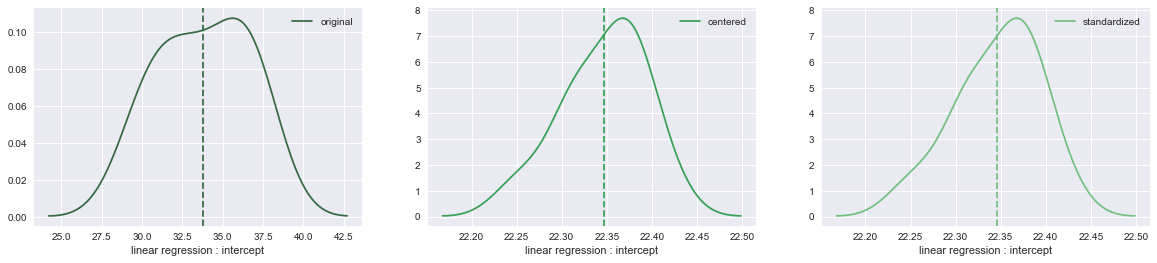

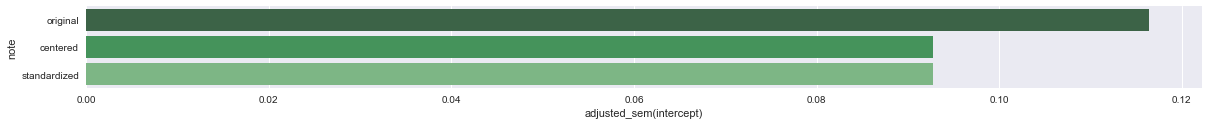

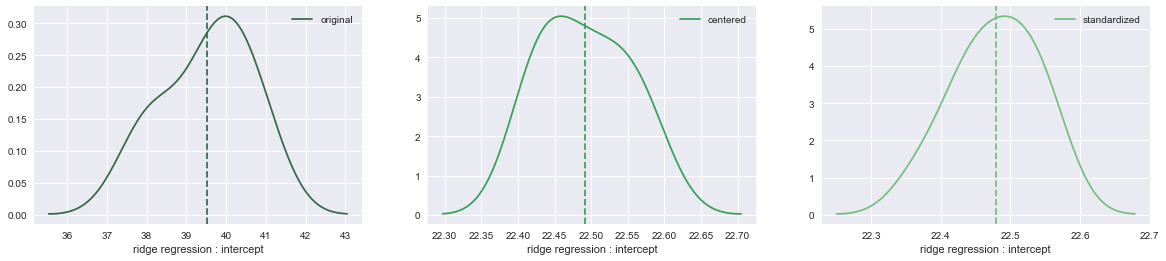

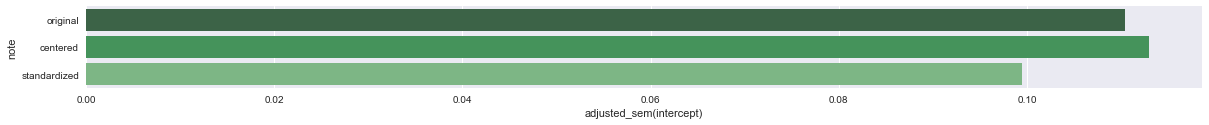

In [23]:
discriminant_values = results['note'].unique()

fig, axs = plt.subplots(nrows = 1, ncols = len(discriminant_values), figsize=(20, 4))
pal = sns.color_palette("Greens_d", len(discriminant_values))

p = 0
for (d_index, d) in enumerate(discriminant_values):
    ax = axs[d_index]
    criteria = (results['note'] == d)
    subset = results[criteria]['intercept']    
    sns.distplot(a = subset, hist = False, kde = True, rug = False, color = pal[p], ax = ax, label = d)   
    ax.axvline(x = subset.mean(), color = pal[p], linestyle='--')
    p += 1
    ax.set_xlabel('linear regression : intercept')
    ax.legend(loc='best')
    
plt.show()


fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 0.5 * len(discriminant_values)))
pal = sns.color_palette("Greens_d", len(discriminant_values))    

ax = axs
sns.barplot(x = 'intercept', y = 'note', data = results, order = discriminant_values, estimator = uc.adjusted_sem, 
            ci = None, ax = ax, palette = pal)  
plt.show()




fig, axs = plt.subplots(nrows = 1, ncols = len(discriminant_values), figsize=(20, 4))
pal = sns.color_palette("Greens_d", len(discriminant_values))

p = 0
for (d_index, d) in enumerate(discriminant_values):
    ax = axs[d_index]
    criteria = (results_ridge['note'] == d)
    subset = results_ridge[criteria]['intercept']    
    sns.distplot(a = subset, hist = False, kde = True, rug = False, color = pal[p], ax = ax, label = d)   
    ax.axvline(x = subset.mean(), color = pal[p], linestyle='--')
    p += 1
    ax.set_xlabel('ridge regression : intercept')
    ax.legend(loc='best')

plt.show()


fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 0.5 * len(discriminant_values)))
pal = sns.color_palette("Greens_d", len(discriminant_values))    

ax = axs
sns.barplot(x = 'intercept', y = 'note', data = results_ridge, order = discriminant_values, estimator = uc.adjusted_sem, 
            ci = None, ax = ax, palette = pal)  
plt.show()


### <font color='#28B463'>Impact on the regression coefficients of the transformed features

<br>

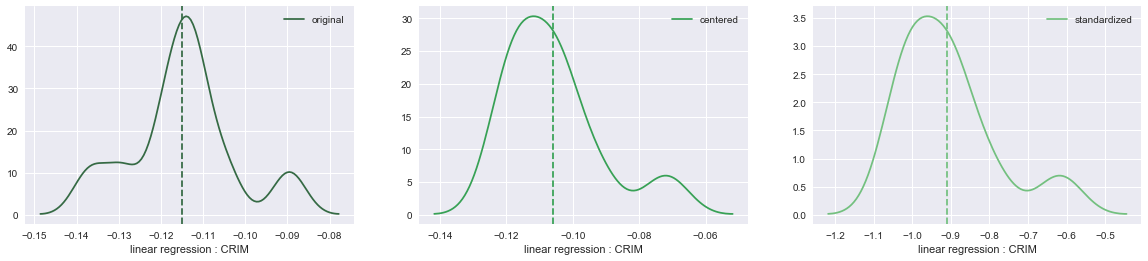

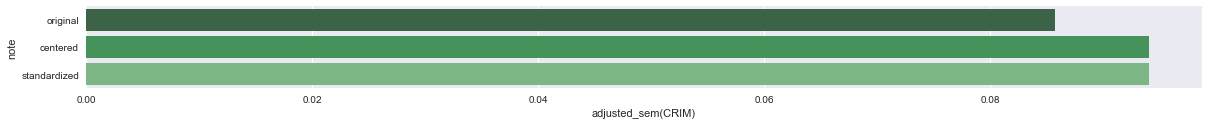

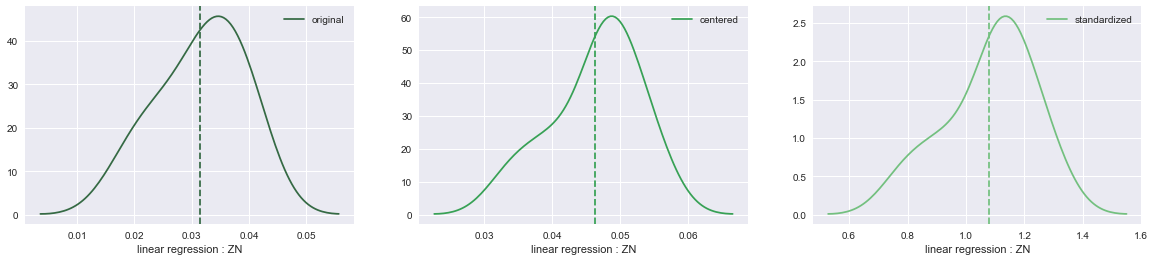

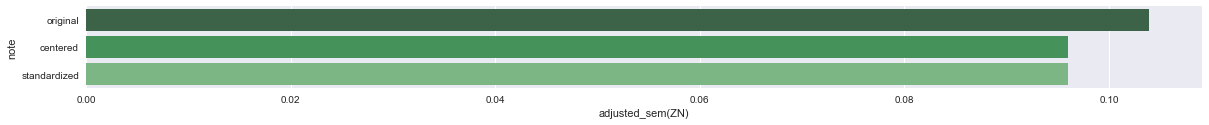

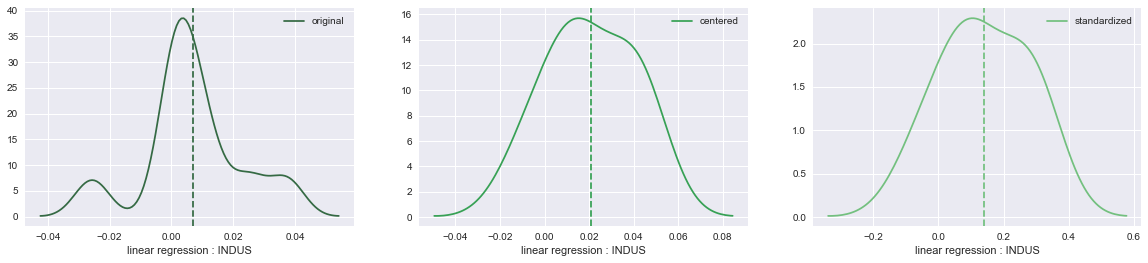

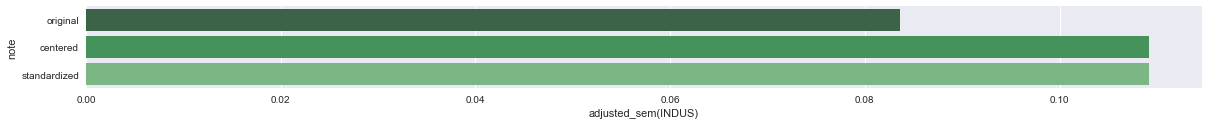

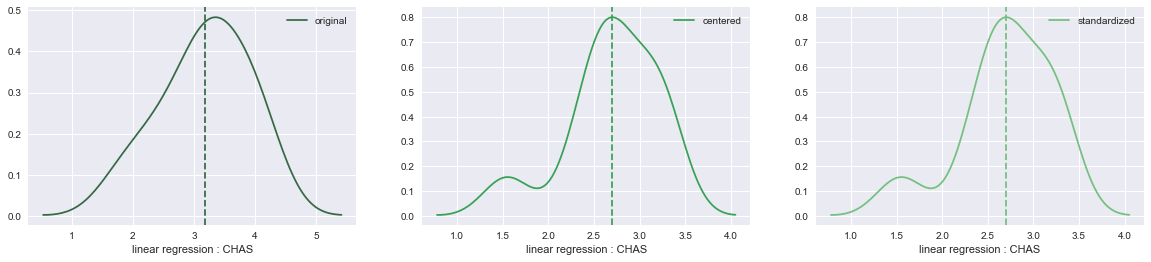

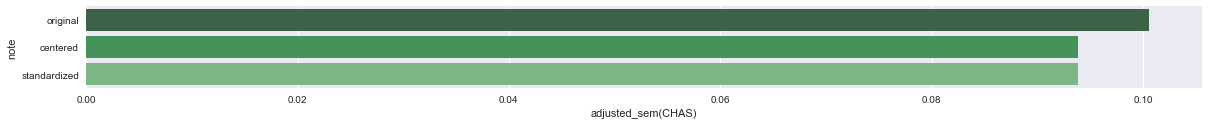

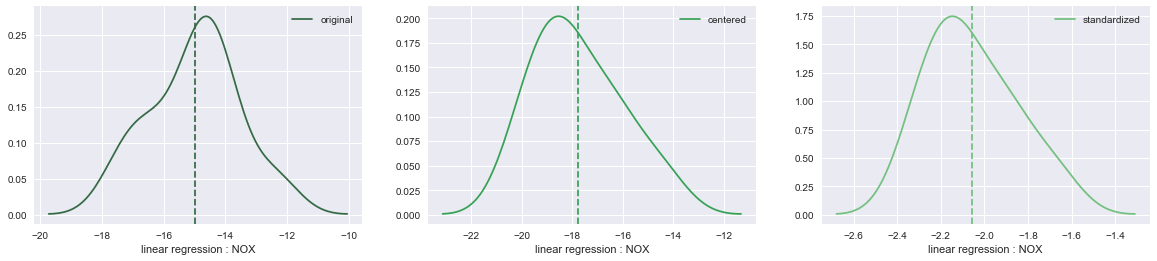

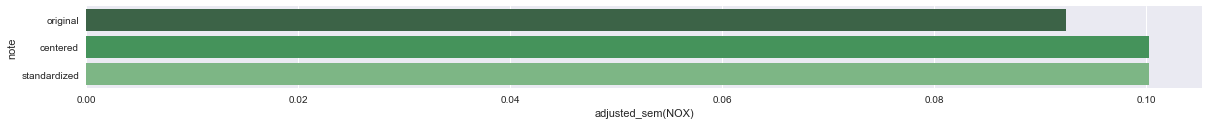

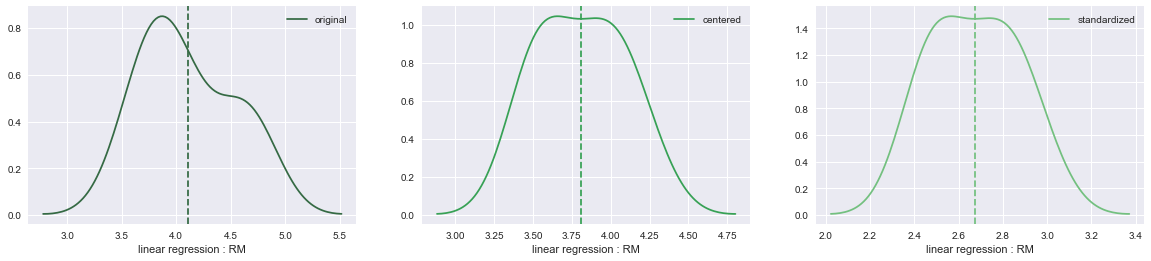

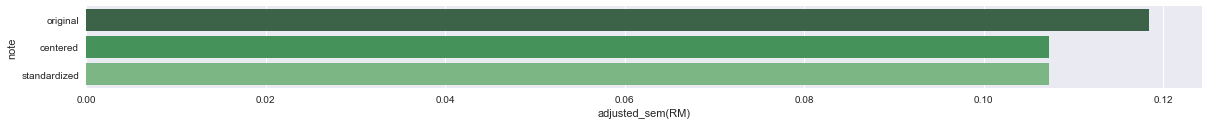

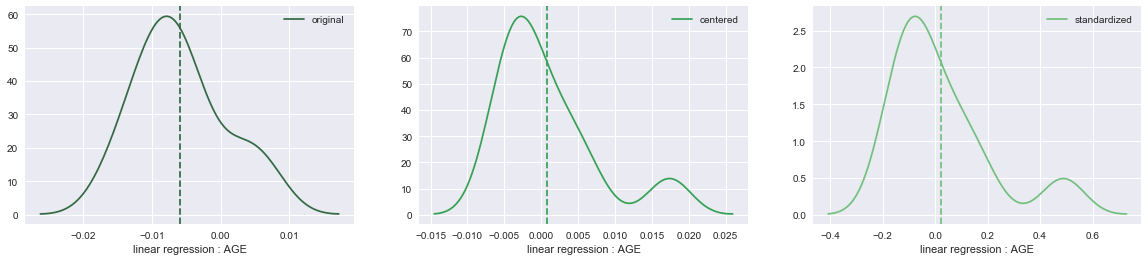

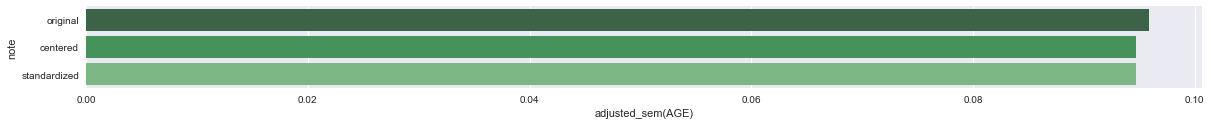

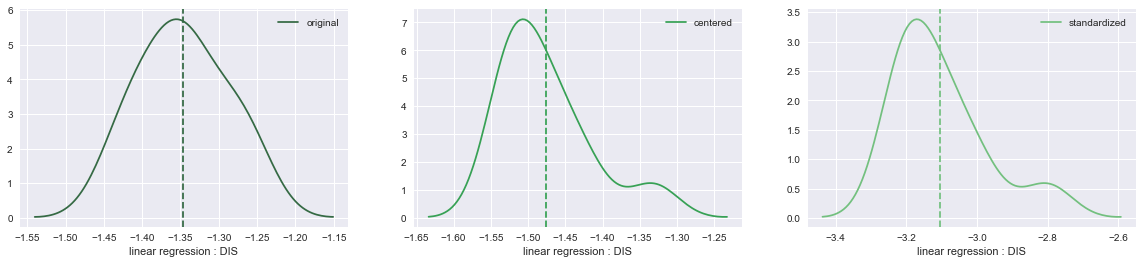

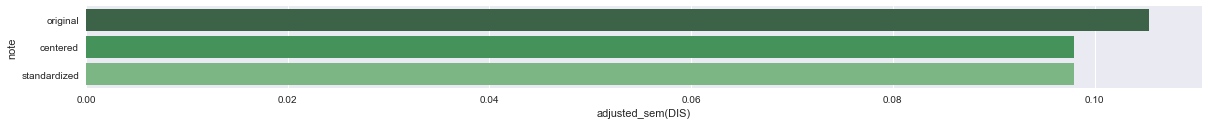

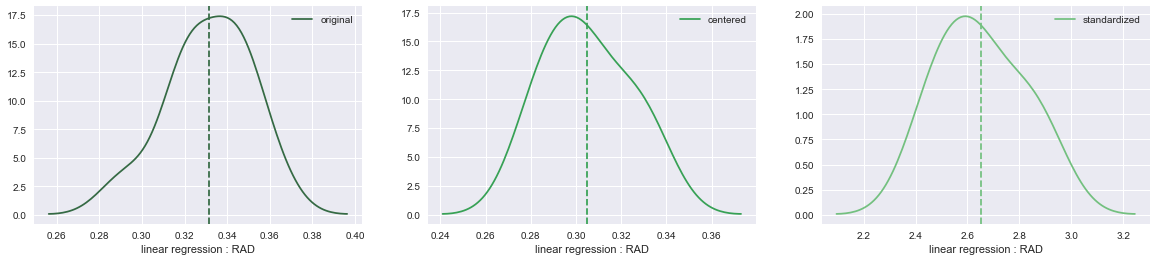

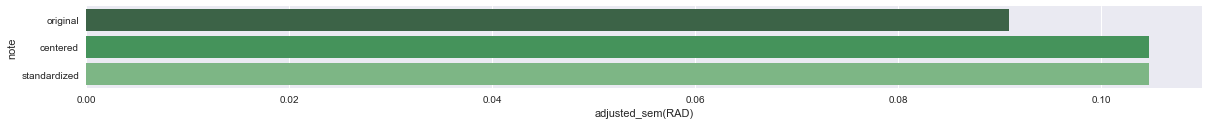

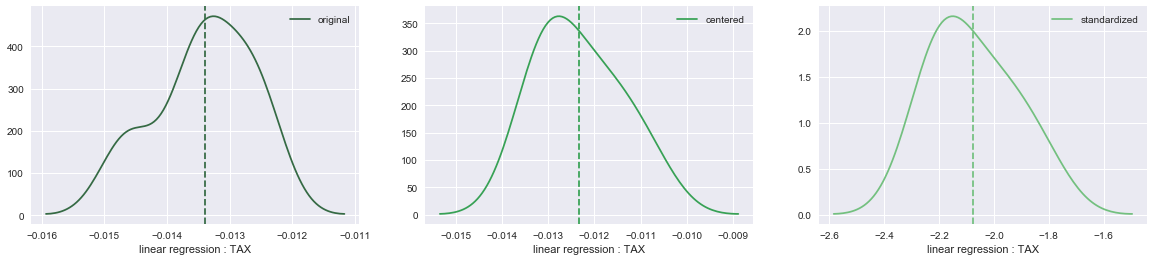

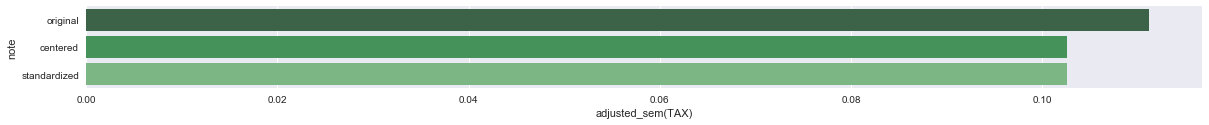

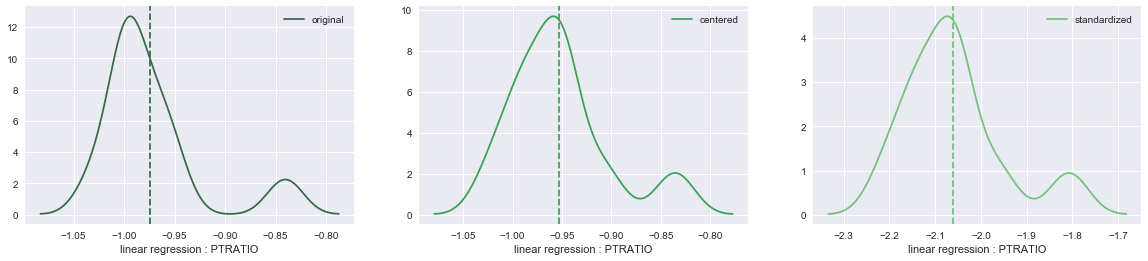

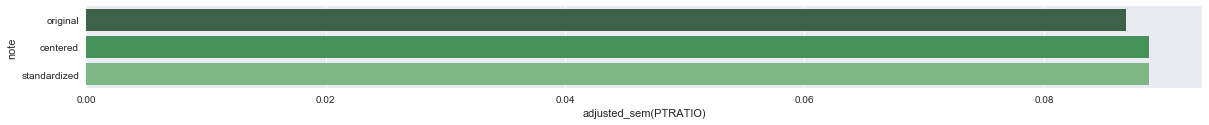

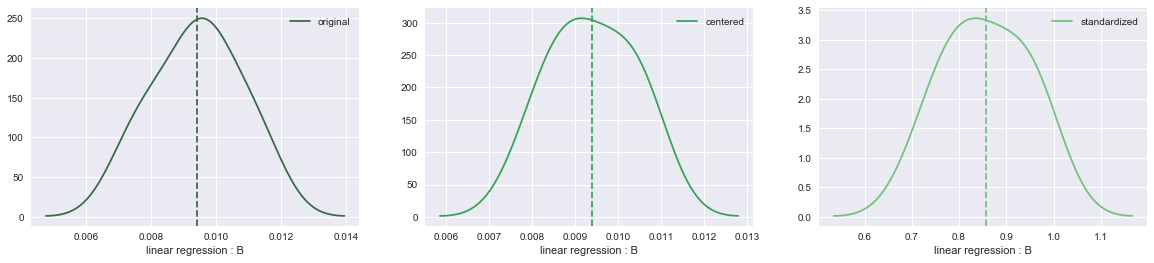

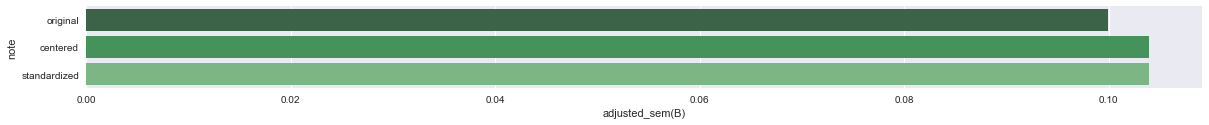

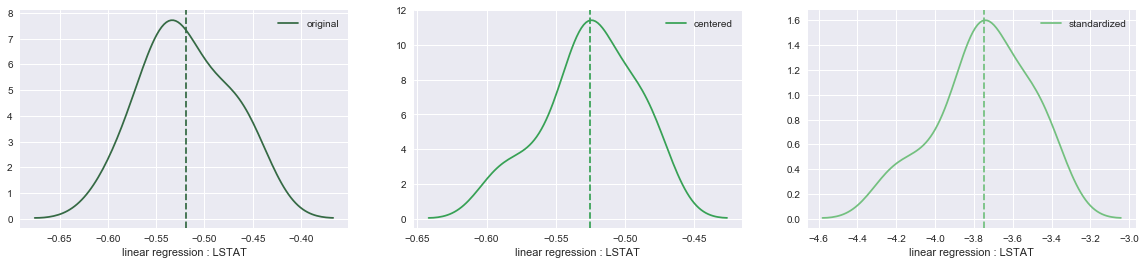

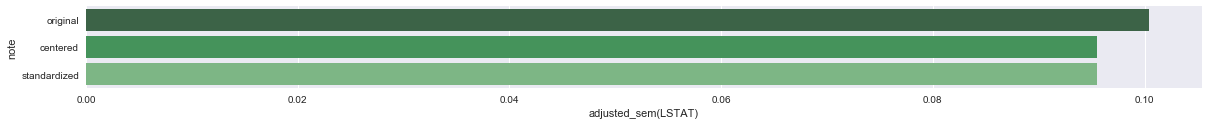

In [24]:
discriminant_values = results['note'].unique()
visualized_features = features


for (f_index, f) in enumerate(visualized_features):
    
    fig, axs = plt.subplots(nrows = 1, ncols = len(discriminant_values), figsize=(20, 4))
    pal = sns.color_palette("Greens_d", len(discriminant_values))
    
    p = 0
    for (d_index, d) in enumerate(discriminant_values):
        ax = axs[d_index]
        criteria = (results['note'] == d)
        subset = results[criteria][f]
        sns.distplot(a = subset, hist = False, kde = True, rug = False, color = pal[p], ax = ax, label = d)   
        ax.axvline(x = subset.mean(), color = pal[p], linestyle='--')
        p += 1
        ax.set_xlabel('linear regression : {0}'.format(f))
        ax.legend(loc='best')
        
    plt.show() 
    
    fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 0.5 * len(discriminant_values)))
    pal = sns.color_palette("Greens_d", len(discriminant_values))  
    ax = axs
    sns.barplot(x = f, y = 'note', data = results, order = discriminant_values, estimator = uc.adjusted_sem, 
                ci = None, ax = ax, palette = pal)  
    plt.show()
    

### <font color='#28B463'>Impact on the regression score

<br>

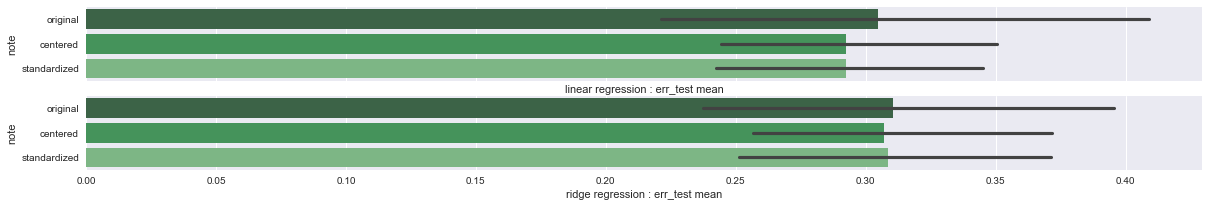

                                            linear regression                                                 ridge regression

err mean (original)      :                             0.3049     err mean (original)      :                            0.3103
err mean (centered)      :                             0.2924     err mean (centered)      :                            0.3069
err mean (standardized)  :                             0.2924     err mean (standardized)  :                            0.3086


In [25]:
discriminant_values = results['note'].unique()

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(20, 0.5*len(discriminant_values)*2), sharex = True)
pal = sns.color_palette("Greens_d", len(discriminant_values))

ax = axs[0]    
sns.barplot(x = 'err_test', y = 'note', data = results, estimator = np.mean, ax = ax, palette = pal)
ax.set_xlabel('linear regression : err_test mean')

ax = axs[1]   
sns.barplot(x = 'err_test', y = 'note', data = results_ridge, estimator = np.mean, ax = ax, palette = pal)
ax.set_xlabel('ridge regression : err_test mean')

plt.show()


template = "{0:>61}{1:>65}" 
print(template.format('linear regression', 'ridge regression'))
print()

template = "{0:25}:{1:>35}     {2:25}:{3:34}" 
for (d_index,d) in enumerate(discriminant_values):
    label_1 = ('err mean ({0})'.format(d))
    label_2 = ('err mean ({0})'.format(d))
    
    criteria = (results_ridge['note'] == d)
    
    subset_1 = results[criteria]['err_test']    
    subset_2 = results_ridge[criteria]['err_test']
    
    print(template.format(label_1, round(subset_1.mean(), 4), label_2, round(subset_2.mean(), 4)))


In [26]:
from statsmodels.stats import diagnostic

linear_list = [
    { 'df_train' : df_train, 'df_test' : df_test, 
     'linear_model_name' : 'LinearRegression', 'linear_model_args' : {'fit_intercept' : True}, 'note' : 'original' },
    #{ 'df_train' : df_sk, 'df_test' : df_sk_test, 
    # 'linear_model_name' : 'LinearRegression', 'linear_model_args' : {'fit_intercept' : True}, 'note' : 'un-skewed' },
    { 'df_train' : df_cnt, 'df_test' : df_cnt_test, 
     'linear_model_name' : 'LinearRegression', 'linear_model_args' : {'fit_intercept' : True}, 'note' : 'centered' },
    { 'df_train' : df_std, 'df_test' : df_std_test, 
     'linear_model_name' : 'LinearRegression', 'linear_model_args' : {'fit_intercept' : True}, 'note' : 'standardized'}    
]

alpha = 10**(2)
ridge_list = [
    { 'df_train' : df_train, 'df_test' : df_test, 'linear_model_name' : 'Ridge', 
     'linear_model_args' : {'alpha' : alpha, 'fit_intercept' : True}, 'note' : 'original' },
    #{ 'df_train' : df_sk, 'df_test' : df_sk_test, 'linear_model_name' : 'Ridge', 
    # 'linear_model_args' : {'alpha' : alpha, 'fit_intercept' : True}, 'note' : 'un-skewed' },
    { 'df_train' : df_cnt, 'df_test' : df_cnt_test, 'linear_model_name' : 'Ridge', 
     'linear_model_args' : {'alpha' : alpha, 'fit_intercept' : True}, 'note' : 'centered' },
    { 'df_train' : df_std, 'df_test' : df_std_test, 'linear_model_name' : 'Ridge', 
     'linear_model_args' : {'alpha' : alpha, 'fit_intercept' : True}, 'note' : 'standardized'}    
]


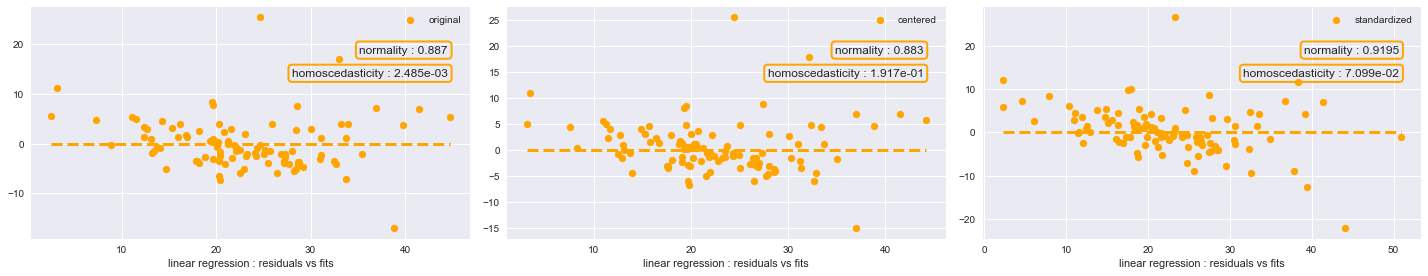

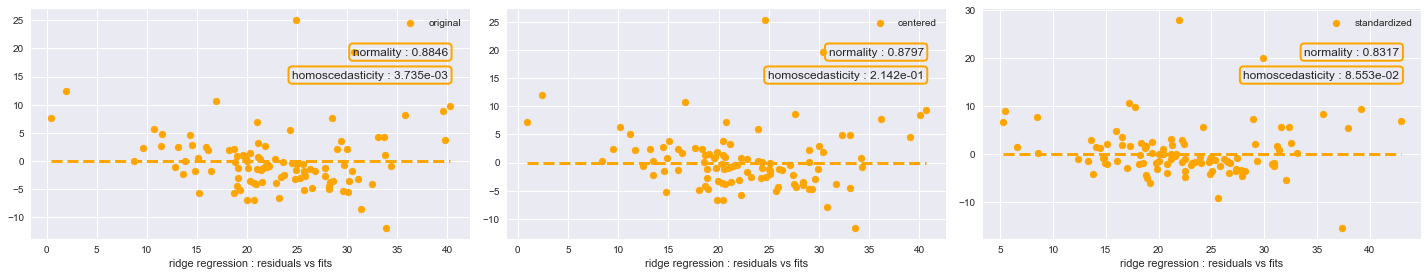

In [27]:
fig, axs = plt.subplots(nrows = 1, ncols = len(linear_list), figsize=(20, 4))
res_color = 'orange'
    
for (l_index, l) in enumerate(linear_list):
    reg_dict = compute_holdout_stats(
        df_train = l['df_train'], df_test = l['df_test'], 
        features = features, target = target, 
        linear_model_name = l['linear_model_name'], linear_model_args = l['linear_model_args'], note = l['note']
    )
    
    normality = round(stats.shapiro(reg_dict['residuals_test'])[0],4)
    homoscedasticity = diagnostic.het_breuschpagan(resid = reg_dict['residuals_test'], exog_het = l['df_test'][features])[3]
            
    x_min = reg_dict['y_pred_test'].min()
    x_max = reg_dict['y_pred_test'].max()
    
    ax = axs[l_index]
    
    ax.scatter(reg_dict['y_pred_test'], reg_dict['residuals_test'], color = res_color, label = reg_dict['note'])
    ax.plot((x_min,x_max), (0,0), linestyle = '--', color = res_color, linewidth = 3)   
    ax.text(x = 0.95, y = 0.8, horizontalalignment='right', s = ('normality : {0}'.format(normality)),  
            transform = ax.transAxes, bbox = dict(boxstyle = "round, pad=0.3", fill = False, ec = res_color, lw = 2))   
    ax.text(x = 0.95, y = 0.7, horizontalalignment='right', s = ('homoscedasticity : {0:.3e}'.format(homoscedasticity)),  
            transform = ax.transAxes, bbox = dict(boxstyle = "round, pad=0.3", fill = False, ec = res_color, lw = 2))   
    ax.legend(loc = 'upper right')
    ax.set_xlabel('linear regression : residuals vs fits')
    
plt.tight_layout()
plt.show()



fig, axs = plt.subplots(nrows = 1, ncols = len(linear_list), figsize=(20, 4))
res_color = 'orange'

for (l_index, l) in enumerate(ridge_list):
    reg_dict = compute_holdout_stats(
        df_train = l['df_train'], df_test = l['df_test'], 
        features = features, target = target, 
        linear_model_name = l['linear_model_name'], linear_model_args = l['linear_model_args'], note = l['note']
    )
    
    normality = round(stats.shapiro(reg_dict['residuals_test'])[0],4)
    homoscedasticity = diagnostic.het_breuschpagan(resid = reg_dict['residuals_test'], exog_het = l['df_test'][features])[3]
        
    x_min = reg_dict['y_pred_test'].min()
    x_max = reg_dict['y_pred_test'].max()
    
    ax = axs[l_index]
    
    ax.scatter(reg_dict['y_pred_test'], reg_dict['residuals_test'], color = res_color, label = reg_dict['note'])
    ax.plot((x_min,x_max), (0,0), linestyle = '--', color = res_color, linewidth = 3)   
    ax.text(x = 0.95, y = 0.8, horizontalalignment='right', s = ('normality : {0}'.format(normality)),  
            transform = ax.transAxes, bbox = dict(boxstyle = "round, pad=0.3", fill = False, ec = res_color, lw = 2))   
    ax.legend(loc = 'upper right')
    
    ax.text(x = 0.95, y = 0.7, horizontalalignment='right', s = ('homoscedasticity : {0:.3e}'.format(homoscedasticity)),  
            transform = ax.transAxes, bbox = dict(boxstyle = "round, pad=0.3", fill = False, ec = res_color, lw = 2))   
    ax.set_xlabel('ridge regression : residuals vs fits')

plt.tight_layout()
plt.show()

## <font color='#28B463'>Ridge Trace

<br>

One of the main obstacles in ridge regression is choosing an appropriate value of the hyper-parameter $k$. In their original paper, Hoerl and Kennard introduced ridge traces : a plot showing the ridge regression coefficients as a function of $k$. Often, the estimated coefficients will vary widely for small values of $k$ and then stabilize. 

<br>
When examining the ridge trace, we should pick a value of $k$ for which most of the variation has already taken place and the regression coefficients have stabilized.

<br>


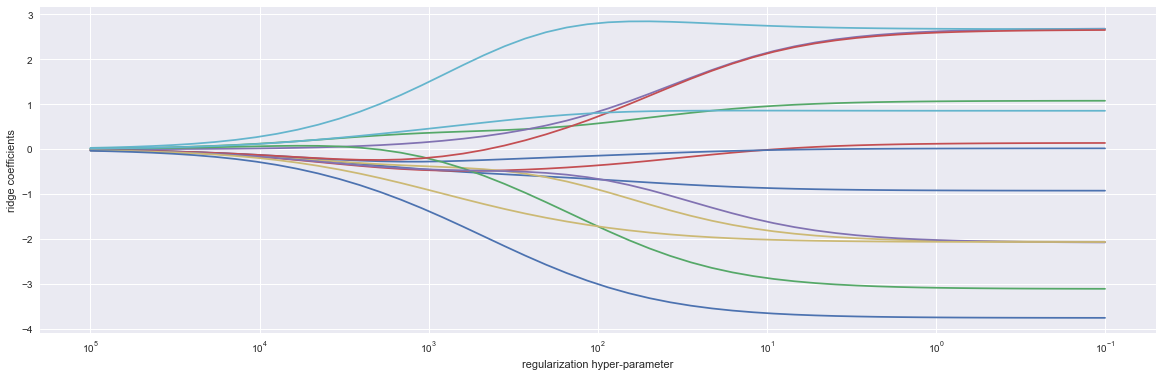

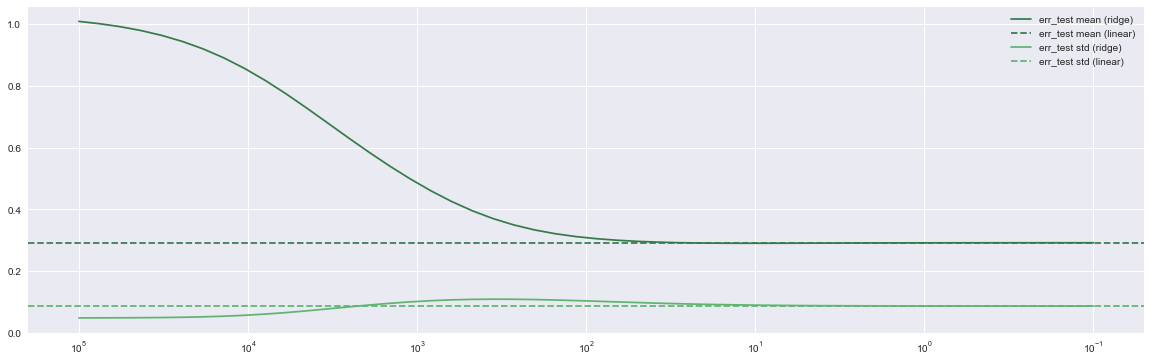

In [28]:
n_alphas = 50
alphas = np.logspace(-1, 5, n_alphas)

coefs = []
for a in alphas:
    ridge = lm.Ridge(alpha = a, fit_intercept = True)
    ridge.fit(df_std[features], df_std[target])    
    coefs.append(ridge.coef_)
    
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 6))    

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('regularization hyper-parameter')
plt.ylabel('ridge coefficients')

plt.show()



err_test_mean = []
err_test_std = []

for a in alphas:
    results_temp = compute_kfold_stats(
        df = df_std, 
        features = features, 
        target = target, 
        linear_model_name = 'Ridge', 
        linear_model_args = {'alpha' : a, 'fit_intercept' : True},
        note = a
    )
    
    #for (f_index, f) in enumerate(['AGE', 'BMI']):
    #    coefs.append(results_temp[f].mean())
    
    err_test_mean.append(results_temp['err_test'].mean())
    err_test_std.append(results_temp['err_test'].std())

criteria = (results['note'] == 'standardized')
subset = results[criteria]['err_test'] 

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 6))    
pal = sns.color_palette("Greens_d", 2)

ax.plot(alphas, err_test_mean, color = pal[0], label = 'err_test mean (ridge)')
ax.axhline(y = subset.mean(), color = pal[0], linestyle='--', label = 'err_test mean (linear)')
ax.plot(alphas, err_test_std, color = pal[1], label = 'err_test std (ridge)')
ax.axhline(y = subset.std(), color = pal[1], linestyle='--', label = 'err_test std (linear)')
ax.legend(loc = 'best')
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis

plt.show()

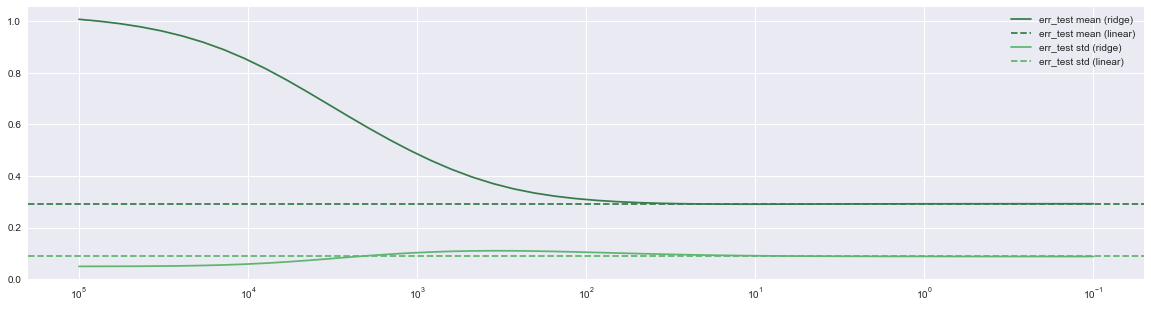

In [29]:
n_alphas = 50
alphas = np.logspace(-1, 5, n_alphas)

err_test_mean = []
err_test_std = []

for a in alphas:
    results_temp = compute_kfold_stats(
        df = df_std, 
        features = features, 
        target = target, 
        linear_model_name = 'Ridge', 
        linear_model_args = {'alpha' : a, 'fit_intercept' : True},
        note = a
    )
    
    #for (f_index, f) in enumerate(['AGE', 'BMI']):
    #    coefs.append(results_temp[f].mean())
    
    err_test_mean.append(results_temp['err_test'].mean())
    err_test_std.append(results_temp['err_test'].std())

criteria = (results['note'] == 'standardized')
subset = results[criteria]['err_test'] 

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 5))    
pal = sns.color_palette("Greens_d", 2)

ax.plot(alphas, err_test_mean, color = pal[0], label = 'err_test mean (ridge)')
ax.axhline(y = subset.mean(), color = pal[0], linestyle='--', label = 'err_test mean (linear)')
ax.plot(alphas, err_test_std, color = pal[1], label = 'err_test std (ridge)')
ax.axhline(y = subset.std(), color = pal[1], linestyle='--', label = 'err_test std (linear)')
ax.legend(loc = 'best')
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis

plt.show()